In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import TFTModel
import torch
freq='2H3T14S'

In [3]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
#         dataframe = pd.read_csv(data_file)
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
#         dataframe.index.name = "Time"

        # if data_file == training_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = True
        # elif data_file == testing_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = False

        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)

In [ ]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe.head()

In [5]:
df_time_indexed = dataframe.set_index('Time')
df_time_indexed

,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
Time,,,,,,,,
1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789
...,...,...,...,...,...,...,...,...
2019-04-19 08:03:34,191.494,747.400,0.000,0.013,0.590,2.064,0.212,190.094
2019-04-19 10:06:49,188.217,747.954,0.000,0.013,0.234,3.252,0.227,194.156
2019-04-19 12:10:03,185.483,746.445,0.003,0.013,0.425,3.746,0.231,194.964


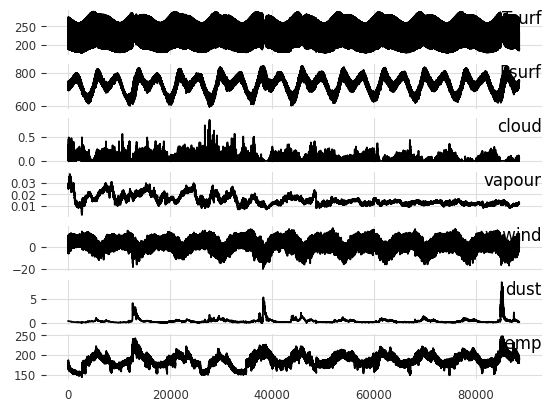

In [6]:
values = df_time_indexed.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_time_indexed.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [7]:
# Calculating a custom datarange index as the frequencies in observed data are irregular
time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
time

DatetimeIndex(['1998-07-15 21:23:39', '1998-07-15 23:26:53',
               '1998-07-16 01:30:07', '1998-07-16 03:33:21',
               '1998-07-16 05:36:35', '1998-07-16 07:39:49',
               '1998-07-16 09:43:03', '1998-07-16 11:46:17',
               '1998-07-16 13:49:31', '1998-07-16 15:52:45',
               ...
               '2019-04-14 21:15:19', '2019-04-14 23:18:33',
               '2019-04-15 01:21:47', '2019-04-15 03:25:01',
               '2019-04-15 05:28:15', '2019-04-15 07:31:29',
               '2019-04-15 09:34:43', '2019-04-15 11:37:57',
               '2019-04-15 13:41:11', '2019-04-15 15:44:25'],
              dtype='datetime64[ns]', length=88560, freq='7394S')

In [8]:
dataframe.index = time
dataframe = dataframe.drop(['Time'], axis=1)
dataframe.head()

,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


In [9]:
series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)

<Axes: xlabel='time'>

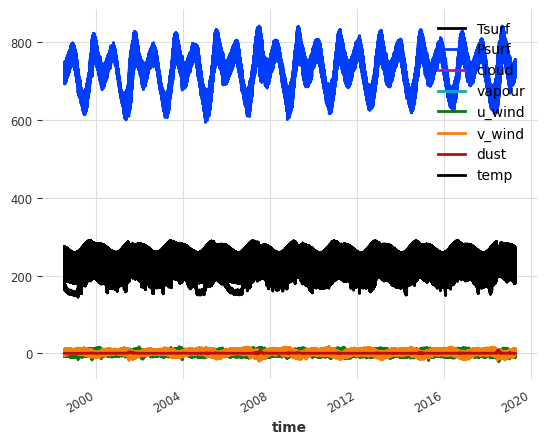

In [11]:
series.plot()

<Axes: xlabel='time'>

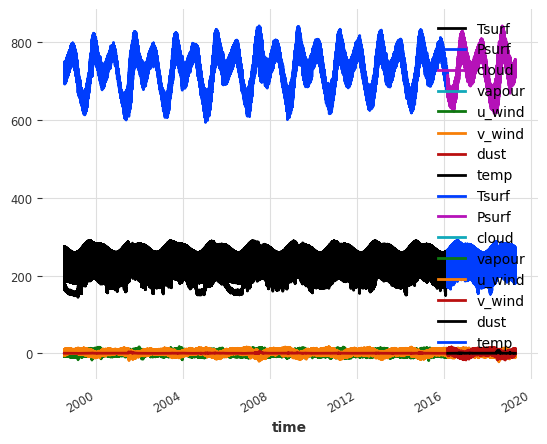

In [12]:
train_series, val_series = series.split_before(0.85)
train_series.plot()
val_series.plot()

In [25]:
train_series['dust']

<TimeSeries (DataArray) (time: 75275, component: 1, sample: 1)>
array([[[0.428]],

       [[0.427]],

       [[0.427]],

       ...,

       [[0.233]],

       [[0.222]],

       [[0.217]]])
Coordinates:
  * time       (time) datetime64[ns] 1998-07-15T21:23:39 ... 2016-03-04T17:49:35
  * component  (component) object 'dust'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [30]:

previous_window = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=previous_window,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=1,
    add_relative_index=True,
    add_encoders=None,
    likelihood=None,  # QuantileRegression is set per default
    loss_fn=torch.nn.MSELoss(),
    random_state=42,
)

In [31]:
my_model.fit(train_series['dust'], past_covariates=train_series, verbose=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 18.2 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K 
7  | static_context_grn                | _GatedResid

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=1, add_encoders=None, random_state=42)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

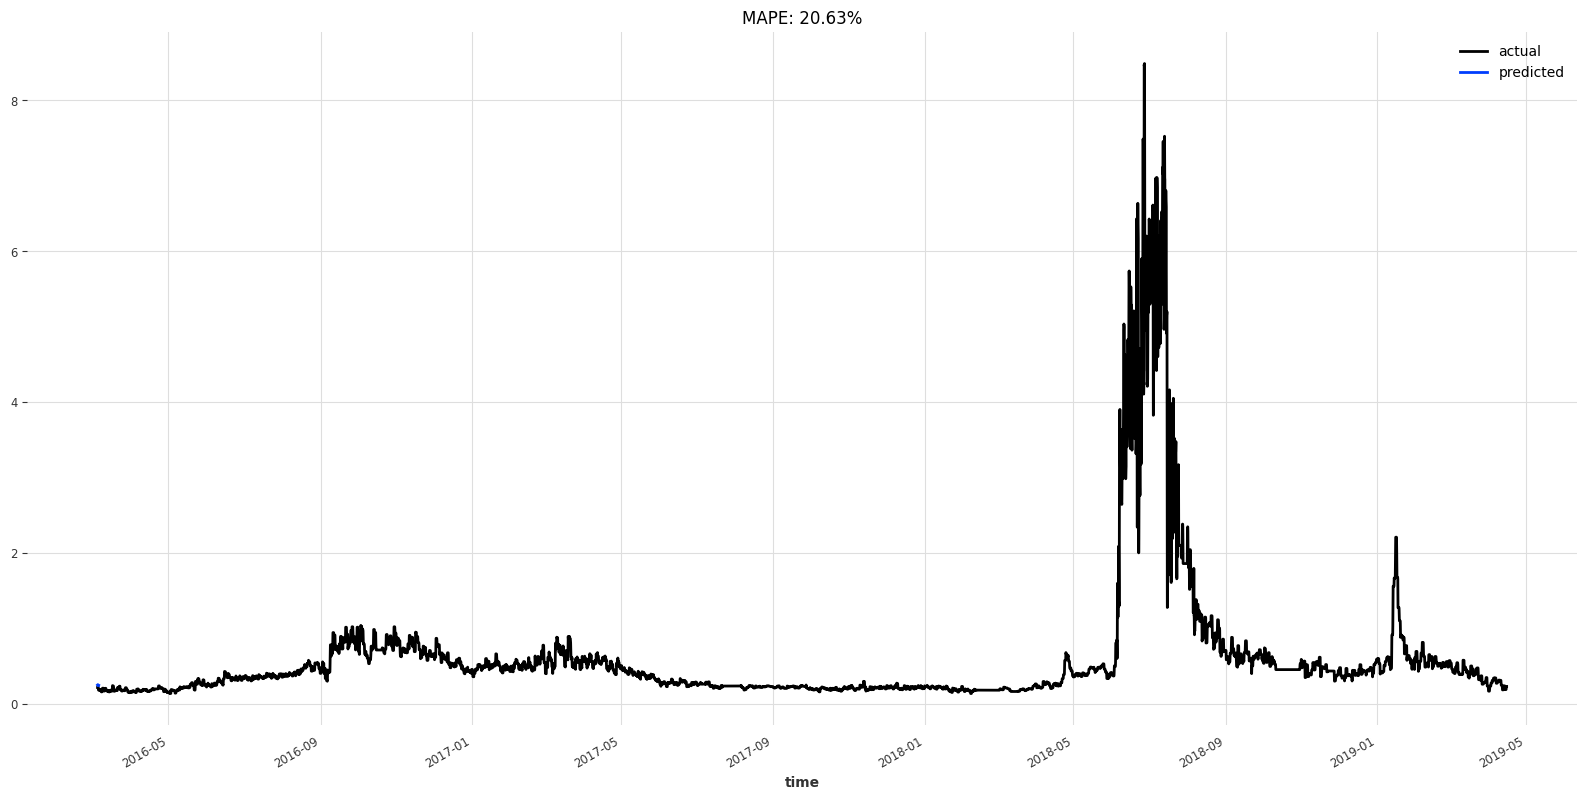

In [54]:
def eval_model(model, n, actual_series, val_series):
    from darts.metrics import mape

    pred_series = model.predict(n=n, num_samples=1000)
    figsize = (9, 6)

    # plot actual series
    plt.figure(figsize=figsize)
    val_series.plot(label="actual")

    # plot predicted series
    pred_series.plot(label='predicted')

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

    return pred_series

horizon = 12

pred = eval_model(my_model, horizon, series['dust'], val_series['dust'])

<Axes: xlabel='time'>

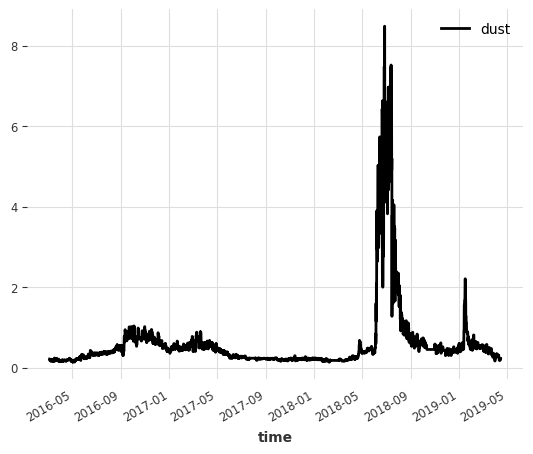

In [55]:
val_series['dust'].plot()

<Axes: xlabel='time'>

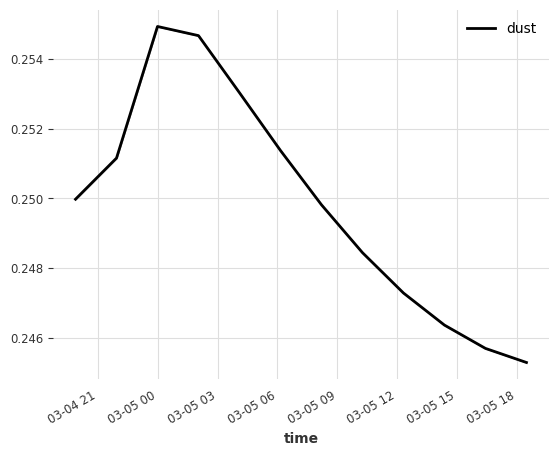

In [57]:
pred.plot()